# Book Recommendation System

## Step 1: Download the dataset directly from kaggle

The dataset used in this project is `Book Recommendation Dataset` downloaded from https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset?select=Books.csv

The dataset contains three csv files.

1) Ratings.csv : Contains the book rating information. Ratings (Book-Rating) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.

2) Users.csv : Contains the user IDs (User-ID) in integers format,Location, Age. Otherwise, these fields contain NULL-values.

3) Books.csv : Books are identified by their respective ISBN.Moreover, some content-based information is given (Book-Title, Book-Author, Year-Of-Publication, Publisher).URLs linking to cover images are also given, appearing in three different flavours (Image-URL-S, Image-URL-M, Image-URL-L), i.e., small, medium, large. These URLs point to the Amazon web site.

In [1]:
#Go to your account, Scroll to API section and Click Expire API Token to remove previous tokens
#Click on Create New API Token - It will download kaggle.json file on your machine.
#Go to your Google Colab project file and run the following commands:
!pip install -q kaggle
from google.colab import files
files.upload()
#Choose the kaggle.json file that you downloaded
#Make directory named kaggle and copy kaggle.json file there.
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

#Change the permissions of the file.
!chmod 600 ~/.kaggle/kaggle.json

#You can check if everything's okay by running this command.
!kaggle datasets list

#Download Data
!kaggle datasets download -d arashnic/book-recommendation-dataset

print("download complete")

Saving kaggle.json to kaggle.json
ref                                                              title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rahulvyasm/netflix-movies-and-tv-shows                           Netflix Movies and TV Shows                         1MB  2024-04-10 09:48:38          20505        457  1.0              
jainaru/world-happiness-report-2024-yearly-updated               World Happiness Report- 2024                       62KB  2024-05-15 19:04:34           1105         28  1.0              
sahirmaharajj/school-student-daily-attendance                    School Student Daily Attendance                     2MB  2024-04-29 19:29:56           5232        111  1.0              
jainaru/thyroid-disease-data   

In [2]:
#unzip the dataset folder amazon-kindle-books-dataset-2023-130k-books
!unzip book-recommendation-dataset

Archive:  book-recommendation-dataset.zip
  inflating: Books.csv               
  inflating: DeepRec.png             
  inflating: Ratings.csv             
  inflating: Users.csv               
  inflating: classicRec.png          
  inflating: recsys_taxonomy2.png    


## Step 2 : Import dependencies

In [3]:
# Importing required libraries
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity   # To get similarity score between items
import pickle

# Importing required libraries for content based recommendation algorithm
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import joblib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, utils, optimizers, callbacks

In [4]:
#Loading Dataset
book = pd.read_csv('Books.csv')
user = pd.read_csv('Users.csv')
rating = pd.read_csv('Ratings.csv')


<ipython-input-4-baa5873f5373>:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  book = pd.read_csv('Books.csv')


# Step 3 : Getting familiar with our data

In [5]:
#printing the shape of data
print(book.shape)
print(user.shape)
print(rating.shape)

(271360, 8)
(278858, 3)
(1149780, 3)


In [6]:
book.head(10)   #print first 10 rows of our books data , book.tail() shows last 10 rows

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
5,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...
6,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000,Berkley Publishing Group,http://images.amazon.com/images/P/0425176428.0...,http://images.amazon.com/images/P/0425176428.0...,http://images.amazon.com/images/P/0425176428.0...
7,0671870432,PLEADING GUILTY,Scott Turow,1993,Audioworks,http://images.amazon.com/images/P/0671870432.0...,http://images.amazon.com/images/P/0671870432.0...,http://images.amazon.com/images/P/0671870432.0...
8,0679425608,Under the Black Flag: The Romance and the Real...,David Cordingly,1996,Random House,http://images.amazon.com/images/P/0679425608.0...,http://images.amazon.com/images/P/0679425608.0...,http://images.amazon.com/images/P/0679425608.0...
9,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002,Scribner,http://images.amazon.com/images/P/074322678X.0...,http://images.amazon.com/images/P/074322678X.0...,http://images.amazon.com/images/P/074322678X.0...


In [7]:
user.head(10)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN
5,6,"santa monica, california, usa",61.0
6,7,"washington, dc, usa",NaN
7,8,"timmins, ontario, canada",NaN
8,9,"germantown, tennessee, usa",NaN
9,10,"albacete, wisconsin, spain",26.0


In [8]:
rating.head(10)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
5,276733,2080674722,0
6,276736,3257224281,8
7,276737,0600570967,6
8,276744,038550120X,7
9,276745,342310538,10


In [9]:
#Show complete information about the user data
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [10]:
#Show complete information about the books data
book.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [11]:
#Show complete information about the rating data
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [12]:
#The following function isnull shows total number of missing values in each field of the data
book.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

In [13]:
user.isnull().sum()

User-ID          0
Location         0
Age         110762
dtype: int64

In [14]:
rating.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [15]:
#check total no of duplicate data in each file
user.duplicated().sum()
book.duplicated().sum()
rating.duplicated().sum()

0

# Step 4: Building recommendation algorithm

## Popularity based recommender

In [16]:
# Merging rating and book dataframes
rating_with_name = rating.merge(book, on='ISBN')
rating_with_name.head(10)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
2,6543,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
3,8680,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
4,10314,034545104X,9,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
5,23768,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
6,28266,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
7,28523,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
8,39002,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
9,50403,034545104X,9,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...


In [17]:
# Calculating the number of ratings and average rating for each book
num_rating_df = rating_with_name.groupby('Book-Title').count()['Book-Rating'].reset_index()
num_rating_df.rename(columns={'Book-Rating': 'Num_rating'}, inplace=True)

avg_rating_df = rating_with_name.groupby('Book-Title').mean(numeric_only=True)['Book-Rating'].reset_index()
avg_rating_df.rename(columns={'Book-Rating': 'Avg_rating'}, inplace=True)

In [18]:
# Merging popularity dataframes and filtering top 100 popular books
popular_df = num_rating_df.merge(avg_rating_df, on='Book-Title')
# first choose books which have got more than 200 ratings, and then sort them according to average rating,
pbr_df = popular_df[popular_df['Num_rating'] >= 200].sort_values('Avg_rating', ascending=False)
pbr_df.head(20)

,Book-Title,Num_rating,Avg_rating
80434,Harry Potter and the Prisoner of Azkaban (Book 3),428,5.852804
80422,Harry Potter and the Goblet of Fire (Book 4),387,5.824289
80441,Harry Potter and the Sorcerer's Stone (Book 1),278,5.737410
80426,Harry Potter and the Order of the Phoenix (Boo...,347,5.501441
60582,Ender's Game (Ender Wiggins Saga (Paperback)),249,5.409639
80414,Harry Potter and the Chamber of Secrets (Book 2),556,5.183453
191612,The Hobbit : The Enchanting Prelude to The Lor...,281,5.007117
187377,The Fellowship of the Ring (The Lord of the Ri...,368,4.948370
80445,Harry Potter and the Sorcerer's Stone (Harry P...,575,4.895652
211384,"The Two Towers (The Lord of the Rings, Part 2)",260,4.880769


In [19]:
# Selecting relevant columns for recommendation
pbr_df = pbr_df.merge(book, on='Book-Title').drop_duplicates('Book-Title')[['Book-Title', 'Book-Author', 'Publisher', 'Image-URL-M', 'Num_rating', 'Avg_rating']]
pbr_df.head()

,Book-Title,Book-Author,Publisher,Image-URL-M,Num_rating,Avg_rating
0,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,Scholastic,http://images.amazon.com/images/P/0439136350.0...,428,5.852804
3,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,Scholastic,http://images.amazon.com/images/P/0439139597.0...,387,5.824289
5,Harry Potter and the Sorcerer's Stone (Book 1),J. K. Rowling,Scholastic,http://images.amazon.com/images/P/0590353403.0...,278,5.737410
9,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,Scholastic,http://images.amazon.com/images/P/043935806X.0...,347,5.501441
13,Ender's Game (Ender Wiggins Saga (Paperback)),Orson Scott Card,Tor Books,http://images.amazon.com/images/P/0312853238.0...,249,5.409639


In [20]:
pbr_df['Image-URL-M'][0]

'http://images.amazon.com/images/P/0439136350.01.MZZZZZZZ.jpg'

In [21]:
import pickle
pickle.dump(pbr_df,open('popularity_based_model.pkl','wb'))

## Collaborative filtering approach based recommender

In [22]:
book.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L'],
      dtype='object')

In [23]:
user.columns

Index(['User-ID', 'Location', 'Age'], dtype='object')

In [24]:
rating.columns

Index(['User-ID', 'ISBN', 'Book-Rating'], dtype='object')

In [25]:
rating_with_name.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
2,6543,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
3,8680,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
4,10314,034545104X,9,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...


In [26]:
# We will consider only those users who have given more than 200 ratings
boolian_index = rating_with_name.groupby('User-ID').count()['Book-Rating'] > 200
boolian_index[boolian_index]

User-ID
254       True
2276      True
2766      True
2977      True
3363      True
          ... 
274308    True
275970    True
277427    True
277639    True
278418    True
Name: Book-Rating, Length: 811, dtype: bool

In [27]:
#Store all the user ids with more than 200 ratings into a variable
experienced_users =  boolian_index[boolian_index].index

print(experienced_users)

Index([   254,   2276,   2766,   2977,   3363,   4017,   4385,   6251,   6323,
         6543,
       ...
       271705, 273979, 274004, 274061, 274301, 274308, 275970, 277427, 277639,
       278418],
      dtype='int64', name='User-ID', length=811)


In [28]:
# Now keep only those rows which has its User-ID present in experienced_users
filtered_rating = rating_with_name[rating_with_name['User-ID'].isin(experienced_users)]

In [29]:
filtered_rating.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
2,6543,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
5,23768,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
7,28523,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
15,77940,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
16,81977,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...


In [30]:
# Find the books which have more than 50
y = filtered_rating.groupby('Book-Title').count()['Book-Rating']>=50
y[y]

Book-Title
1984                                                                 True
1st to Die: A Novel                                                  True
2nd Chance                                                           True
4 Blondes                                                            True
A Bend in the Road                                                   True
                                                                     ... 
Year of Wonders                                                      True
You Belong To Me                                                     True
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values    True
Zoya                                                                 True
\O\" Is for Outlaw"                                                  True
Name: Book-Rating, Length: 706, dtype: bool

In [31]:
# store all the book titles which has greater than or equal to 50 ratings
books_with_50_plus_ratings = y[y].index

print(books_with_50_plus_ratings)

Index(['1984', '1st to Die: A Novel', '2nd Chance', '4 Blondes',
       'A Bend in the Road', 'A Case of Need',
       'A Child Called \It\": One Child's Courage to Survive"',
       'A Civil Action', 'A Day Late and a Dollar Short', 'A Fine Balance',
       ...
       'Winter Solstice', 'Wish You Well', 'Without Remorse',
       'Wizard and Glass (The Dark Tower, Book 4)', 'Wuthering Heights',
       'Year of Wonders', 'You Belong To Me',
       'Zen and the Art of Motorcycle Maintenance: An Inquiry into Values',
       'Zoya', '\O\" Is for Outlaw"'],
      dtype='object', name='Book-Title', length=706)


In [32]:
#keep only those rows in the final ratings table which has no of ratings for book >=50 and userid with more than 200 ratings
final_ratings = filtered_rating[filtered_rating['Book-Title'].isin(books_with_50_plus_ratings)]

In [33]:
final_ratings

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
63,278418,0446520802,0,The Notebook,Nicholas Sparks,1996,Warner Books,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...
65,3363,0446520802,0,The Notebook,Nicholas Sparks,1996,Warner Books,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...
66,7158,0446520802,10,The Notebook,Nicholas Sparks,1996,Warner Books,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...
69,11676,0446520802,10,The Notebook,Nicholas Sparks,1996,Warner Books,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...
74,23768,0446520802,6,The Notebook,Nicholas Sparks,1996,Warner Books,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...
...,...,...,...,...,...,...,...,...,...,...
1026724,266865,0531001725,10,The Catcher in the Rye,Jerome David Salinger,1973,Scholastic Library Pub,http://images.amazon.com/images/P/0531001725.0...,http://images.amazon.com/images/P/0531001725.0...,http://images.amazon.com/images/P/0531001725.0...
1027923,269566,0670809381,0,Echoes,Maeve Binchy,1986,Penguin USA,http://images.amazon.com/images/P/0670809381.0...,http://images.amazon.com/images/P/0670809381.0...,http://images.amazon.com/images/P/0670809381.0...
1028777,271284,0440910927,0,The Rainmaker,John Grisham,1995,Island,http://images.amazon.com/images/P/0440910927.0...,http://images.amazon.com/images/P/0440910927.0...,http://images.amazon.com/images/P/0440910927.0...
1029070,271705,B0001PIOX4,0,Fahrenheit 451,Ray Bradbury,1993,Simon &amp; Schuster,http://images.amazon.com/images/P/B0001PIOX4.0...,http://images.amazon.com/images/P/B0001PIOX4.0...,http://images.amazon.com/images/P/B0001PIOX4.0...


In [34]:
pivot_table = final_ratings.pivot_table(index = 'Book-Title',columns = 'User-ID',values = 'Book-Rating',)

In [35]:
#fill NaN values with 0
pt = pivot_table.fillna(0)

In [36]:
pt

User-ID,254,2276,2766,2977,3363,4017,4385,6251,6323,6543,...,271705,273979,274004,274061,274301,274308,275970,277427,277639,278418
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Bend in the Road,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
You Belong To Me,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Cosine similarity ranges from -1 to 1 and is calculated as the dot product between two vectors divided by their magnitudes.


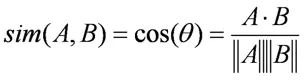

In [37]:
# We will find similarity between each books.
similarity_scores = cosine_similarity(pt)
similarity_scores[0]

array([1.        , 0.10255025, 0.01220856, 0.        , 0.05367224,
       0.02774901, 0.08216491, 0.13732869, 0.03261686, 0.03667591,
       0.02322418, 0.06766487, 0.02083978, 0.09673735, 0.13388865,
       0.08303112, 0.11153543, 0.05100411, 0.02517784, 0.11706383,
       0.        , 0.14333793, 0.07847534, 0.06150451, 0.08723968,
       0.        , 0.07009814, 0.13658681, 0.07600328, 0.12167134,
       0.00768046, 0.01473221, 0.        , 0.07965814, 0.04522617,
       0.01556271, 0.09495938, 0.0182307 , 0.02610465, 0.07984012,
       0.11679969, 0.0569124 , 0.08354155, 0.08471898, 0.08785938,
       0.05491435, 0.0548505 , 0.27026514, 0.09779123, 0.06016046,
       0.08958835, 0.06748675, 0.        , 0.04468098, 0.01920872,
       0.        , 0.05629067, 0.00557964, 0.07877059, 0.05219479,
       0.18908177, 0.        , 0.01240656, 0.02984572, 0.04279502,
       0.12680125, 0.16566735, 0.        , 0.13357242, 0.06615478,
       0.        , 0.        , 0.        , 0.10968075, 0.02806

In [38]:
#similarity_scores matrix contains the similarity score of each 706 books with other 706 books
similarity_scores.shape

(706, 706)

Now we will create a function `recommend` that will take name of a book then it will return 5 recommendation which are similar to the entered book title.

https://www.geeksforgeeks.org/python-lambda-anonymous-functions-filter-map-reduce/

In [53]:
def recommend(book_title):
  '''
  This function takes book title as an input from user for making recommendations
  Arguments:
  book_title : title of the book
  '''
  #for avoiding case sensitiveness
  book_title = book_title.upper()
  pt['title'] = pt.index  #copy all index(book titles) into a separate column book_title
  pt['title'] = pt['title'].str.upper()  #convert the entire book_title column to uppercase

  if book_title not in list(pt['title']):
    print("The book is not available")
    return None
  else:
    print("The book is available")
    print("The recommendations are...")
    #index fetch of the entered title
    index_no_of_book = np.where(pt['title'] == book_title)[0][0]

    #Now access the similarity score vector at row no index,and find the 5 books with which the similarity score of the entered book is highest.
    sim_score_of_similar_books = sorted(list(similarity_scores[index_no_of_book]),key=lambda x:x, reverse = True)[1:6]   #[1:6]:the highest similarity of any book will be with itself, hence the book itself can't be recommended. Therefore, start from index 1 instead of 0 and go upto 5

    print(sim_score_of_similar_books)
    #find the index of each element of sim_score_of_similar_books in similarity_score matrix
    list_of_indexes = []
    for i in range(0,5):
      list_of_indexes.append(np.where(list(similarity_scores[index_no_of_book]) == sim_score_of_similar_books[i])[0][0])
      #print(list_of_indexes)

    #Return the original Book_Titles
    book_titles = list(pt.index[list_of_indexes])

    data=[] #list to store book-title, author, and image url of recommended books
    # Get more data about the book listed in book_titles
    for title in book_titles:
      item = []  # list to store book-title, author and image url of one book
      temp_df = book[book['Book-Title'] == title]
      item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Title'].values))
      item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Author'].values))
      item.extend(list(temp_df.drop_duplicates('Book-Title')['Image-URL-M'].values))
      data.append(item)
    return data

In [54]:
# utilize the recommend function to make recommendations
recommended_books = recommend("pride and prejudice")

#print the recommended books
if recommended_books != None:
  print(recommended_books)

The book is available
The recommendations are...
[0.2569023893381495, 0.2439515067666388, 0.20390006041886904, 0.19635908162608814, 0.19281549158555333]
[['The English Patient', 'Michael Ondaatje', 'http://images.amazon.com/images/P/0679745203.01.MZZZZZZZ.jpg'], ['How to Be Good', 'Nick Hornby', 'http://images.amazon.com/images/P/1573229326.01.MZZZZZZZ.jpg'], ['Two for the Dough', 'Janet Evanovich', 'http://images.amazon.com/images/P/0671001795.01.MZZZZZZZ.jpg'], ['Rising Sun', 'MICHAEL CRICHTON', 'http://images.amazon.com/images/P/0345380371.01.MZZZZZZZ.jpg'], ['4 Blondes', 'Candace Bushnell', 'http://images.amazon.com/images/P/0451203895.01.MZZZZZZZ.jpg']]


In [55]:
pickle.dump(pt,open('pt.pkl','wb'))
pickle.dump(similarity_scores,open('similarity_scores.pkl','wb'))
pickle.dump(book,open('book.pkl','wb'))

## Content filtering based recommender

In [56]:
book['Year-Of-Publication'] = book['Year-Of-Publication'].replace('DK Publishing Inc', np.nan).replace('Gallimard', np.nan).astype(float)

In [ ]:
# Contains all the user, book, ratings data in a single dataframe
ratings_merged = rating.merge(user, how='left').merge(book, how='left')
ratings_merged.head()

,User-ID,ISBN,Book-Rating,Location,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,276725,034545104X,0,"tyler, texas, usa",NaN,Flesh Tones: A Novel,M. J. Rose,2002.0,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
1,276726,0155061224,5,"seattle, washington, usa",NaN,Rites of Passage,Judith Rae,2001.0,Heinle,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...
2,276727,0446520802,0,"h, new south wales, australia",16.0,The Notebook,Nicholas Sparks,1996.0,Warner Books,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...
3,276729,052165615X,3,"rijeka, n/a, croatia",16.0,Help!: Level 1,Philip Prowse,1999.0,Cambridge University Press,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...
4,276729,0521795028,6,"rijeka, n/a, croatia",16.0,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001.0,Cambridge University Press,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...


In [ ]:
# for item/book network we are going to use following features to make recommendations
ITEM_FEATURES = ['Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher']

# for user network we are going to use following features to make recommendations
USER_FEATURES = ['Location', 'Age']

TARGET = ['Book-Rating']

x_item = ratings_merged[ITEM_FEATURES]
x_user = ratings_merged[USER_FEATURES]
y = ratings_merged[TARGET]

x_item.shape, x_user.shape, y.shape

((1149780, 4), (1149780, 2), (1149780, 1))

### preprocessing of the data
**TF-IDF vectorizer** : Term Frequency Inverse Document Frequency.
This is very common algorithm to transform text into a meaningful representation of numbers which is used to fit machine algorithm for prediction. tf-idf consider overall documents of weight of words.

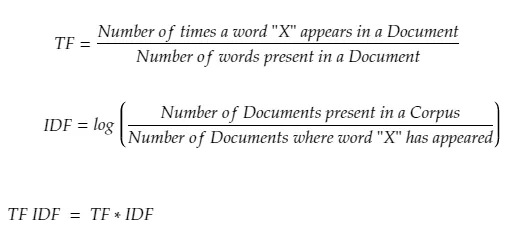

reference: https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a



In [ ]:
# Univariate imputer for completing missing values with simple strategies.
# Replace missing values using a descriptive statistic (e.g. mean, median,most frequent,or constant)
impute_blanks = lambda: SimpleImputer(strategy='constant', fill_value='')  # Missing values will be replaced by fill_value='',empty string
impute_median = lambda: SimpleImputer(strategy='median')                   # Missing values will be replaced by median

def get_2d_to_1d(df):
    return df.reshape(-1)

reshape = lambda: FunctionTransformer(get_2d_to_1d)

tfidf = lambda: TfidfVectorizer(analyzer='char', ngram_range=(2, 2))
scale = lambda: StandardScaler()

#create pipelines for different features. pipeline shows which method to use for filling missing values, which method to use for reshaping, which encoder to use for different columns
preprocessor_items = ColumnTransformer([
    ('Book-Title', Pipeline([('impute', impute_blanks()), ('reshape', reshape()), ('encoder', tfidf())]), ['Book-Title']),
    ('Book-Author', Pipeline([('impute', impute_blanks()), ('reshape', reshape()), ('encoder', tfidf())]), ['Book-Author']),
    ('Year-Of-Publication', Pipeline([('impute', impute_median()), ('encoder', scale())]), ['Year-Of-Publication']),
    ('Publisher', Pipeline([('impute', impute_blanks()), ('reshape', reshape()), ('encoder', tfidf())]), ['Publisher']),
])

preprocessor_users = ColumnTransformer([
    ('Location', Pipeline([('impute', impute_blanks()), ('reshape', reshape()), ('encoder', tfidf())]), ['Location']),
    ('Age', Pipeline([('impute', impute_median()), ('encoder', scale())]), ['Age']),
])

ratings_scaler = MinMaxScaler()

x_item = preprocessor_items.fit_transform(x_item)
x_user = preprocessor_users.fit_transform(x_user)
y = ratings_scaler.fit_transform(y).reshape(-1)
x_item.shape, x_user.shape, y.shape

((1149780, 5571), (1149780, 1695), (1149780,))

x_item, x_user, y are sparse arrays.

In [ ]:
def sparse_array_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.sparse.reorder(tf.SparseTensor(indices, coo.data, coo.shape))

In [ ]:
x_item = sparse_array_to_sparse_tensor(x_item)
x_user = sparse_array_to_sparse_tensor(x_user)
y = y

In [ ]:
x_item

SparseTensor(indices=tf.Tensor(
[[      0      34]
 [      0      47]
 [      0      53]
 ...
 [1149778    5179]
 [1149778    5205]
 [1149779    4139]], shape=(55674987, 2), dtype=int64), values=tf.Tensor([0.16264905 0.2100846  0.15770213 ... 0.30346908 0.29298717 0.11794202], shape=(55674987,), dtype=float64), dense_shape=tf.Tensor([1149780    5571], shape=(2,), dtype=int64))

In [ ]:
x_user

SparseTensor(indices=tf.Tensor(
[[      0      45]
 [      0      46]
 [      0     108]
 ...
 [1149779    1311]
 [1149779    1397]
 [1149779    1694]], shape=(26404586, 2), dtype=int64), values=tf.Tensor(
[ 0.30274526  0.10637508  0.15927226 ...  0.10131042  0.31070625
 -2.01616138], shape=(26404586,), dtype=float64), dense_shape=tf.Tensor([1149780    1695], shape=(2,), dtype=int64))

In [ ]:
y

array([0. , 0.5, 0. , ..., 1. , 1. , 0.8])

### Bulilding neural network for content based filtering

In [ ]:
items_input = layers.Input(shape=(x_item.shape[1]))
items_ = layers.Dense(32, activation='relu')(items_input)
items_vector = layers.Dense(32, activation='relu')(items_)

users_input = layers.Input(shape=(x_user.shape[1]))
users_ = layers.Dense(32, activation='relu')(users_input)
users_vector = layers.Dense(32, activation='relu')(users_)

items_norm = tf.linalg.l2_normalize(items_vector, axis=1)
users_norm = tf.linalg.l2_normalize(users_vector, axis=1)

output = layers.Dot(axes=1)([items_norm, users_norm])

model = models.Model([items_input, users_input], output)

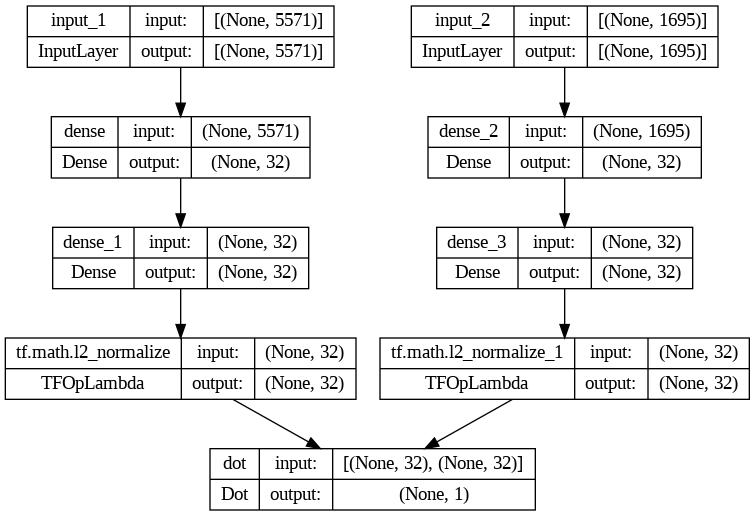

In [ ]:
utils.plot_model(model, show_shapes=True, expand_nested=True)

In [ ]:
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(1e-4))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 5571)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1695)]               0         []                            
                                                                                                  
 dense (Dense)               (None, 32)                   178304    ['input_1[0][0]']             
                                                                                                  
 dense_2 (Dense)             (None, 32)                   54272     ['input_2[0][0]']             
                                                                                              

In [ ]:
es = callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, restore_best_weights=True)
rlp = callbacks.ReduceLROnPlateau(monitor='loss', patience=2, verbose=1)

model.fit([x_item, x_user], y, callbacks=[es, rlp], epochs=250)

Epoch 1/250
35931/35931 [==============================] - 239s 7ms/step - loss: 0.1301 - lr: 1.0000e-04
Epoch 2/250
35931/35931 [==============================] - 241s 7ms/step - loss: 0.1235 - lr: 1.0000e-04
Epoch 3/250
35931/35931 [==============================] - 247s 7ms/step - loss: 0.1210 - lr: 1.0000e-04
Epoch 4/250
35931/35931 [==============================] - 241s 7ms/step - loss: 0.1192 - lr: 1.0000e-04
Epoch 5/250
35931/35931 [==============================] - 241s 7ms/step - loss: 0.1178 - lr: 1.0000e-04
Epoch 6/250
35931/35931 [==============================] - 243s 7ms/step - loss: 0.1167 - lr: 1.0000e-04
Epoch 7/250
35931/35931 [==============================] - 242s 7ms/step - loss: 0.1158 - lr: 1.0000e-04
Epoch 8/250
35931/35931 [==============================] - 240s 7ms/step - loss: 0.1149 - lr: 1.0000e-04
Epoch 9/250
35931/35931 [==============================] - 240s 7ms/step - loss: 0.1142 - lr: 1.0000e-04
Epoch 10/250
35931/35931 [=============================

### Saving the models

In [ ]:
model_items = models.Model(items_input, items_vector)
model_users = models.Model(users_input, users_vector)

joblib.dump(preprocessor_items, 'preprocessor_items.bin')
joblib.dump(preprocessor_users, 'preprocessor_users.bin')

model_items.save('model_items.h5')
model_users.save('model_users.h5')
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
input_items_vec = layers.Input(shape=(32))
norm_items = tf.linalg.l2_normalize(input_items_vec, axis=1)
input_users_vec = layers.Input(shape=(32))
norm_users = tf.linalg.l2_normalize(input_users_vec, axis=1)
output = layers.Dot(axes=1)([norm_items, norm_users])
dot_model = models.Model([input_items_vec, input_users_vec], output)
dot_model.save('dot_model.h5')

### Getting Recommendations

In [ ]:
new_user = pd.DataFrame({'Location': ['new delhi, india'], 'Age': [25]})
new_user_preprocessed = preprocessor_users.transform(new_user)
new_user_vector = model_users.predict(new_user_preprocessed)
new_user_vector.shape

1/1 [==============================] - 0s 483ms/step


(1, 32)

In [ ]:
all_item_preprocessed = preprocessor_items.transform(book[ITEM_FEATURES])
all_item_vector = model_items.predict(all_item_preprocessed)
all_item_vector.shape

8480/8480 [==============================] - 17s 2ms/step


(271360, 32)

In [ ]:
new_user_vector = np.broadcast_to(new_user_vector, all_item_vector.shape)
preds = dot_model.predict([new_user_vector, all_item_vector])
book['preds'] = preds

8480/8480 [==============================] - 13s 2ms/step


In [ ]:
book.sort_values('preds', ascending=False).head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,preds
136415,0760717494,So-Ju Eye to Eye B&amp;n,Taschen,1999.0,Benedikt Taschen Verlag,http://images.amazon.com/images/P/0760717494.0...,http://images.amazon.com/images/P/0760717494.0...,http://images.amazon.com/images/P/0760717494.0...,0.736660
223349,3499222221,Jenseits von Afrika.,Tania Blixen,1999.0,Rowohlt Tb.,http://images.amazon.com/images/P/3499222221.0...,http://images.amazon.com/images/P/3499222221.0...,http://images.amazon.com/images/P/3499222221.0...,0.735960
166751,1556615639,"From the Ashes (Jennie Mcgrady Mystery, No 10)",Patricia H. Rushford,1997.0,Bethany House Publishers,http://images.amazon.com/images/P/1556615639.0...,http://images.amazon.com/images/P/1556615639.0...,http://images.amazon.com/images/P/1556615639.0...,0.732957
208271,0822218143,Edward Albee's the Play About the Baby,Edward Albee,2002.0,Dramatists Play Service Inc,http://images.amazon.com/images/P/0822218143.0...,http://images.amazon.com/images/P/0822218143.0...,http://images.amazon.com/images/P/0822218143.0...,0.731750
176336,9505156057,Mafalda 5,Quino,2004.0,Ediciones de la Flor S.R.L.,http://images.amazon.com/images/P/9505156057.0...,http://images.amazon.com/images/P/9505156057.0...,http://images.amazon.com/images/P/9505156057.0...,0.728844
